<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

**Цель** - чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи**:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

На первом этапе изучения данных, мы импортируем необходимые библиотеки, которые пригодятся для исследования, и изучим общую информацию о датасетах.

In [30]:
!pip install -U scikit-learn==1.1.3 -q
!pip install catboost -q
!pip install statsmodels -q

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from numpy.random import RandomState
import lightgbm as lgb
import seaborn as sns
import scipy
from scipy import stats as st
import sklearn as sk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels. tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [32]:
plt.rcParams['figure.figsize'] = (6, 5)

In [33]:
def download(filename):
    df = pd.read_csv(filename, parse_dates=['datetime'])
    display(df.head())
    df.info()
    return df

In [34]:
data = download('/datasets/taxi.csv') 

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [35]:
def research(filename):
    isna = filename.isna().sum()
    print("Количество пропущенных значений\n", isna, "\n")
    per = isna/ len(filename) * 100
    print("Количество пропущенных значений в процентах\n", per, "\n")
    duplicates = filename.duplicated().sum()
    print("Количество дубликатов\n", duplicates, "\n")

In [36]:
research(data) 

Количество пропущенных значений
 datetime      0
num_orders    0
dtype: int64 

Количество пропущенных значений в процентах
 datetime      0.0
num_orders    0.0
dtype: float64 

Количество дубликатов
 0 



In [37]:
data = data.set_index('datetime')

Проверим, в хронологическом ли порядке расположены дата и время.

In [38]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

In [39]:
data = data.resample('1H').sum()

In [40]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


В датасете 2 столбца. Описание данных:
* `datetime` — дата и время
* `num_orders` — количество заказов

Количество значений совпадает во всех колонках, значит, вероятно, нет пропущенных данных. Тип данных datetime был приведен к необходимому.

**Таким образом, на этапом этапе исследования были произведены загрузка данных, изучение общей информации о них, ресемплирование данных по одному часу, тип данных столбца datetime был приведен к необходимому.**

## Анализ

Построим график временного ряда, сравним его с графиком скользящего среднего.

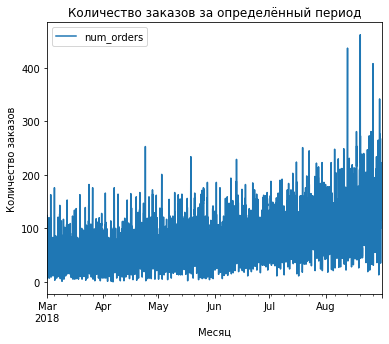

In [41]:
data.plot()
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов за определённый период');

In [42]:
dataa = data.rolling(10, closed='left').mean()

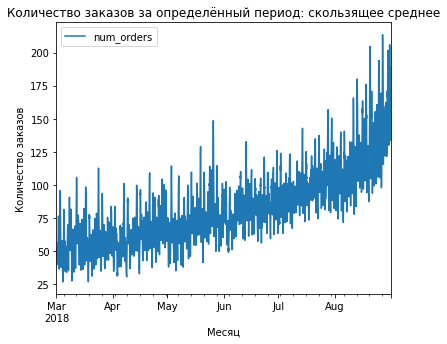

In [43]:
dataa.plot()
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов за определённый период: скользящее среднее');

Таким образом, видно, что количество заказов увеличивается к лету. 

Разберём тренды и сезонность.

In [44]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [45]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Данные представлены за 6 месяцев: с 1 марта 2018 года до 31 августа 2018 года.

In [46]:
decomposed = seasonal_decompose(data)

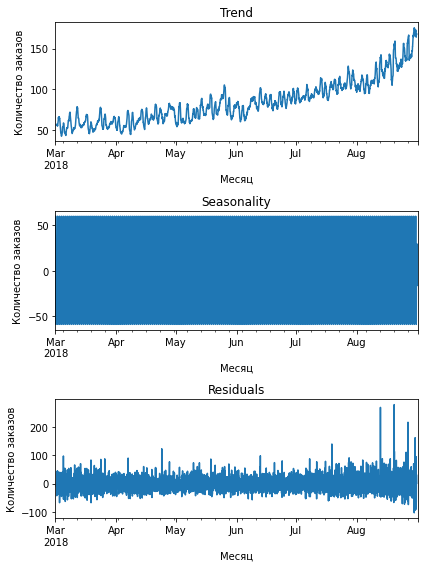

In [47]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Residuals')
plt.tight_layout()

Рассмотрим сезонность за месяц и за неделю.

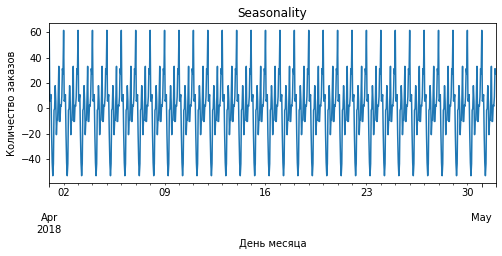

In [48]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-05-01']) 

plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.title('Seasonality');

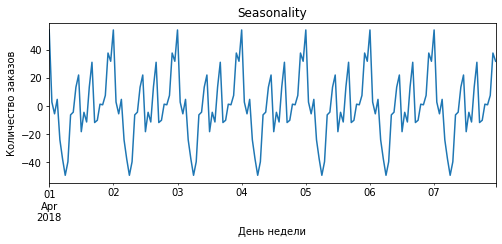

In [49]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-04-07']) 

plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Seasonality');

Пока никаких закономерностей не наблюдается, посмотрим сезонность за день.

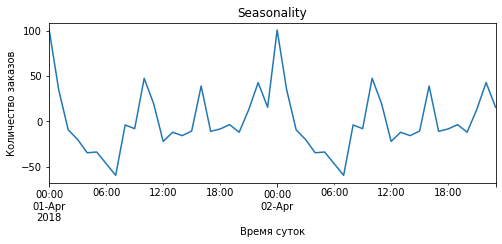

In [50]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-04-02']) 

plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Время суток')
plt.ylabel('Количество заказов')
plt.title('Seasonality');

Таким образом, сезонная составляющая за день показывает, что количество заказов резко уменьшается в период с 00.00 до 6 утра. Затем наблюдаются пики примерно в 10 часов утра и в 16. Самый большой пик - в 00 часов.

Проверим гипотезу о нестационарности ряда с помощью теста Дики-Фуллера. 

H0 : Временной ряд является нестационарным.
    
H1 : временной ряд является стационарным.

In [51]:
result = adfuller(data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')


if result[1] <= 0.05:
    print("Ряд данных стационарен на уровне значимости 5%")
else:
    print("Ряд данных нестационарен на уровне значимости 5%")

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values:
	1%: -3.431842162413052
	5%: -2.8621993540813637
	10%: -2.567120978470452
Ряд данных стационарен на уровне значимости 5%


In [52]:
result = adfuller(data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')


if result[1] <= 0.01:
    print("Ряд данных стационарен на уровне значимости 1%")
else:
    print("Ряд данных нестационарен на уровне значимости 1%")

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values:
	1%: -3.431842162413052
	5%: -2.8621993540813637
	10%: -2.567120978470452
Ряд данных нестационарен на уровне значимости 1%


**Итак, ряд нестационарен на уровне значимости 1%. Кроме того, рассмотрим ещё и график, на котором увидим нестационарность ряда.**

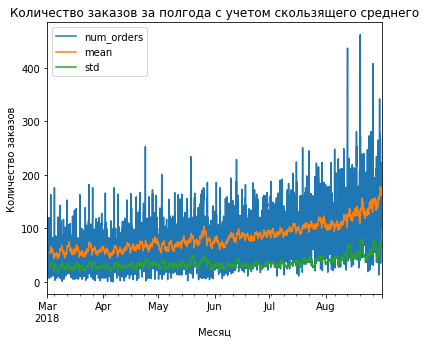

In [53]:
data['mean'] = data['num_orders'].rolling(40).mean()
data['std'] = data['num_orders'].rolling(40).std()
data.plot()
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов за полгода с учетом скользящего среднего');

Таким образом, временной ряд нестационарен, так как скользящее среднее увеличивается со временем (к концу лета). Так как ряд нестационарен, сделаем его стационарным.Для этого найдем разности временного ряда.

**Итак, на этом этапе исследования нами было установлено, что:**
- количество заказов увеличивается к лету, так как это связано с тем, что август - месяц, в котором большинство людей едут на отдых. 
- количество заказов резко уменьшается в период с 00.00 до 6 утра. Затем наблюдаются пики примерно в 10 часов утра и в 16. Самый большой пик - в 00 часов. 
- Данные представлены за 6 месяцев: с 1 марта 2018 года до 31 августа 2018 года.
- Природа сезонности обусловлена тем, что примерно в 10 и в 16 часов утра люди заказывают такси, так как часто назначаются на утреннее и обеднее время рейсы. Самый большой пик в 00 обусловлен тем, что людям сложнее добраться до аэропорта / из него, так как общественный транспорт в это время уже почти не работает. 
- количество заказов не зависит от месяца и дня недели.
- тест Дики-Фуллера показал, что временной ряд был нестационарным.

## Обучение

На этом этапе мы обучим модель. Целевой признак - num_orders. Сделаем тестовую выборку размером 10% от исходных данных.

Создадим признаки для горизонта прогнозирования.
Напишем функцию для создания признаков.

In [57]:
def make_features(data, max_lag, rolling_mean_size):
    df_mf = data.copy()
    df_mf['day'] = df_mf.index.day
    df_mf['dayofweek'] = df_mf.index.dayofweek
    df_mf['hour'] = df_mf.index.hour
    
    for lag in range(1, max_lag + 1):
        df_mf['lag_{}'.format(lag)] = df_mf['num_orders'].shift(lag)
    df_mf['rolling_mean'] = df_mf['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_mf.dropna()

In [58]:
data_new = make_features(data, 4, 4)

In [59]:
data_new = data_new.dropna()

In [60]:
data_new.duplicated().sum()

0

In [61]:
RANDOM_STATE = 42
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 15:00:00 2018-08-13 17:00:00
2018-08-13 18:00:00 2018-08-31 23:00:00


In [62]:
X_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

In [63]:
num_columns = X_train.select_dtypes(include=['number']).columns

Создаём общий пайплайн для подготовки данных

In [64]:
data_preprocessor = ColumnTransformer(
     [('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [65]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [66]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + list(range(2, 7)),
        'models__max_features': [None] + list(range(2, 7)),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(),'passthrough']   
    },

]

In [67]:
tscv = TimeSeriesSplit(n_splits=5)

In [68]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    random_state=RANDOM_STATE,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [69]:
model = random_search.fit(X_train, y_train)

In [70]:
print('Лучшая модель и её параметры:\n\n', model.best_estimator_)
print('Метрика:\n\n', -model.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['mean', 'std', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'rolling_mean'],
      dtype='object'))])),
                ('models',
                 DecisionTreeRegressor(max_depth=6, max_features=5,
                                       random_state=42))])
Метрика:

 31.330325401684615


Обучим модель CatBoost

In [43]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [44]:
params = {'iterations': 200,
          'learning_rate': 0.05,
          'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'random_seed': 0,
          'verbose': 100,
          }

In [45]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=3,
    shuffle=False,
    partition_random_seed=0,
    verbose=False,
    early_stopping_rounds=100,
    type='TimeSeries'
)

Training on fold [0/3]

bestTest = 26.39182776
bestIteration = 199

Training on fold [1/3]

bestTest = 25.23175205
bestIteration = 199

Training on fold [2/3]

bestTest = 32.93348872
bestIteration = 196



In [46]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
199,199,28.187236,4.155079,16.232538,2.105099


In [47]:
n_iters = cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]['iterations'].values[0]

In [48]:
params = {'iterations': n_iters,
          'learning_rate': 0.05,
          'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'random_seed': 0,
          'verbose': 100,
          }

In [49]:
model2 = CatBoostRegressor(**params)

In [50]:
model2.fit(train_pool);

0:	learn: 37.7176488	total: 3.06ms	remaining: 605ms
100:	learn: 22.5958779	total: 230ms	remaining: 224ms
198:	learn: 20.4877361	total: 449ms	remaining: 0us


**Таким образом, лучшей на тренировочных данных стала модель CatBoost с параметрами 'iterations': 199,
          'learning_rate': 0.05,
          'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'random_seed': 0,
          'verbose': 100 и метрикой RMSE - 20.**

## Тестирование

Выполним предсказания на лучшей модели.  

In [52]:
pred_cat = model2.predict(X_test)
mean_squared_error(y_test, pred_cat, squared=False)

46.627785548409655

**Таким образом, были выполнены предсказания и метрика RMSE получилась равной 46.6. Проверим модель на адекватность.**

In [53]:
dummy_regressor = DummyRegressor(strategy = 'mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)
mean_squared_error(y_test, y_pred_dummy, squared=False)

84.64836056311967

Следовательно, модель с тюнингом на тестовой выборке показала себя лучше.

Визуализируем предсказания лучшей модели и сравнить их с правильными ответами в формате линейного графика.

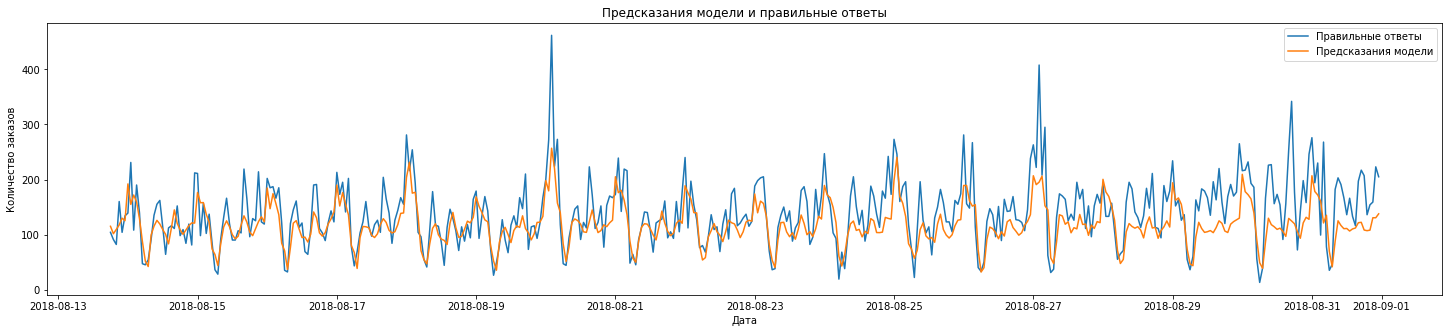

In [54]:
plt.figure(figsize=(25,5))
plt.plot(y_test.index, y_test, label='Правильные ответы')
plt.plot(y_test.index, pred_cat, label='Предсказания модели')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Предсказания модели и правильные ответы')
plt.legend();

Модель делает хорошие предсказания в случае отсутствия выбросов. Когда в конце августа значения начали в среднем возрастать, модель не предсказала это, поэтому значения стали менее точными. 

**Итак, на данном этапе исследования было выявлено, что:**
- Были выполнены предсказания и метрика RMSE получилась равной 46.6.
- Модель делает хорошие предсказания в случае отсутствия выбросов. Когда в конце августа значения начали в среднем возрастать, модель не предсказала это, поэтому значения стали менее точными.

## Выводы

Таким образом, наше исследование было проведено в несколько этапов:
- ознакомление с данными
- предобработка данных (на этом этапе были проверены данные на пропущенные значения, дубликаты, аномалии, изменен тип данных даты).
- количество заказов увеличивается к лету. 
- количество заказов резко уменьшается в период с 00.00 до 6 утра. Затем наблюдаются пики примерно в 10 часов утра и в 16. Самый большой пик - в 00 часов.
- Данные представлены за 6 месяцев: с 1 марта 2018 года до 31 августа 2018 года.
- количество заказов не зависит от месяца и дня недели.
- лучшей на тренировочных данных стала модель CatBoost с параметрами 'iterations': 199, 'learning_rate': 0.05, 'eval_metric': 'RMSE', 'loss_function': 'RMSE', 'random_seed': 0, 'verbose': 100 и метрикой RMSE - 20.
- Были выполнены предсказания и метрика RMSE получилась равной 46.6.
- Модель делает хорошие предсказания в случае отсутствия выбросов. Когда в конце августа значения начали в среднем возрастать, модель не предсказала это, поэтому значения стали менее точными.

Таким образом, данная модель обучена и готова для внедрения в бизнес.
